In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

## Dataset Introduction
This dataset contains two sets.

The first set is all goods, the second set contains goods and defective products.

You need to classify the products into defective ones or not, and calculate the accuracy.

The benchmark is accuracy.

In [4]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os


class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        自定義數據集。
        :param root_dir: 數據目錄（包含圖片的文件夾）
        :param transform: 圖像處理的變換（如 Resize, ToTensor 等）
        """
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = [os.path.join(root_dir, f) for f in os.listdir(
            root_dir) if os.path.isfile(os.path.join(root_dir, f))]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        """
        獲取第 idx 張圖片及其標籤。
        這裡假設文件名包含類別（如 'bottle_01.jpg'，其中 'bottle' 是類別）。
        """
        img_path = self.image_paths[idx]
        img = Image.open(img_path).convert("RGB")
        label = os.path.basename(img_path).split('_')[0]  # 提取文件名前綴作為標籤
        if self.transform:
            img = self.transform(img)
        return img, label

In [80]:
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# 圖片處理
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize images to 64x64
    transforms.ToTensor(),       # Convert image to PyTorch tensor
])

# 設定路徑
train_root = './data/train'
val_root = './data/val'

# 建立訓練和驗證 DataLoader
train_loaders = {}
val_loaders = {}

# 批次大小
batch_size = 256

for category in os.listdir(train_root):
    category_train_path = os.path.join(train_root, category)
    category_val_path = os.path.join(val_root, category)

    # 確保目錄存在
    if os.path.isdir(category_train_path):
        train_dataset = CustomDataset(
            root_dir=category_train_path, transform=transform)
        train_loader = DataLoader(
            train_dataset, batch_size=batch_size, num_workers=4, shuffle=True)
        train_loaders[category] = train_loader

        print(f"Category: {category}")
        print(f"Train samples: {len(train_dataset)}")

    if os.path.isdir(category_val_path):
        val_dataset = CustomDataset(
            root_dir=category_val_path, transform=transform)
        val_loader = DataLoader(
            val_dataset, batch_size=batch_size, num_workers=4, shuffle=False)
        val_loaders[category] = val_loader

        print(f"Validation samples: {len(val_dataset)}")

Category: bottle
Train samples: 167
Validation samples: 42
Category: pill
Train samples: 213
Validation samples: 54
Category: capsule
Train samples: 175
Validation samples: 44
Category: cable
Train samples: 179
Validation samples: 45
Category: toothbrush
Train samples: 48
Validation samples: 12


In [81]:
if torch.cuda.is_available():
    device = 'cuda:0'
    print("[INFO] Current device:", torch.cuda.get_device_name(
        torch.cuda.current_device()), f", device num:{torch.cuda.current_device()}")
elif torch.has_mps:
    device = 'mps'
    print("[INFO] Current device: MAC OS Metal Performance Shaders.")
else:
    device = 'cpu'
    print("[INFO] Current device: CPU")
    print(
        "*"*50, "\n[WARNING] You may need to change the device to GPU or MPS to get better performance.")
    print("*"*50)
device = torch.device(device)

[INFO] Current device: NVIDIA GeForce RTX 3090 Ti , device num:0


In [8]:
import torch
import torch.nn as nn


class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        identity = x
        if self.downsample:
            identity = self.downsample(x)

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out += identity  # Residual connection
        out = self.relu(out)

        return out


In [17]:
class VAE(nn.Module):
    def __init__(self, latent_dim=64):
        super(VAE, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            ResidualBlock(3, 32, stride=2, downsample=nn.Conv2d(3, 32, kernel_size=1, stride=2)),
            ResidualBlock(32, 64, stride=2, downsample=nn.Conv2d(32, 64, kernel_size=1, stride=2)),
            ResidualBlock(64, 128, stride=2, downsample=nn.Conv2d(64, 128, kernel_size=1, stride=2)),
            ResidualBlock(128, 256, stride=2, downsample=nn.Conv2d(128, 256, kernel_size=1, stride=2)),
            nn.Flatten(),  # Flatten the feature map
        )

        # Fully connected layers for latent space
        self.fc_mu = nn.Linear(256 * 8 * 8, latent_dim)
        self.fc_logvar = nn.Linear(256 * 8 * 8, latent_dim)

        # Decoder
        self.fc_decoder = nn.Linear(latent_dim, 256 * 8 * 8)
        self.decoder = nn.Sequential(
            nn.Unflatten(1, (256, 8, 8)),  # Reshape back to feature map
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid(),  # Normalize to [0, 1]
        )

    def reparameterize(self, mu, logvar):
        """Reparameterization trick: sample latent vector z ~ N(mu, sigma^2)"""
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        # Encode the input
        encoded = self.encoder(x)
        mu = self.fc_mu(encoded)
        logvar = self.fc_logvar(encoded)

        # Reparameterize to sample latent vector
        z = self.reparameterize(mu, logvar)

        # Decode the latent vector
        decoded = self.decoder(self.fc_decoder(z))

        return decoded, mu, logvar


In [10]:
def loss_function(recon_x, x, mu, logvar, beta=1.0):
    """
    VAE 损失函数，包括重建损失（MSE）和 KL 散度。
    :param recon_x: 重建后的输出
    :param x: 输入数据
    :param mu: 潜在空间的均值
    :param logvar: 潜在空间的对数方差
    :param beta: KL 散度的权重（默认是 1.0）
    :return: 总损失
    """
    # 重建损失 (MSE)
    recon_loss = F.mse_loss(recon_x, x, reduction='sum')
    # KL 散度 (批量计算)
    kl_divergence = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())

    # 总损失 (带可选 beta 权重)
    return recon_loss + beta * kl_divergence

In [11]:
train_losses = []
val_losses = []


def train_vae(model, train_loader, val_loader, optimizer, epochs=5):
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()  # Set the model to training mode
        train_loss = 0.0
        val_loss = 0.0

        for batch in train_loader:
            inputs, _ = batch  # Ignore labels if they exist
            # Move data to the same device as the model
            inputs = inputs.to(next(model.parameters()).device)

            optimizer.zero_grad()  # Reset gradients

            # Forward pass
            recon, mu, log_var = model(inputs)

            # Loss calculation
            loss = loss_function(recon, inputs, mu, log_var)

            # Backpropagation
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        for batch in val_loader:
            inputs, _ = batch  # Ignore labels if they exist
            # Move data to the same device as the model
            inputs = inputs.to(next(model.parameters()).device)

           # Forward pass
            recon, mu, log_var = model(inputs)

            # Loss calculation
            loss = loss_function(recon, inputs, mu, log_var)

            val_loss += loss.item()

        # Average training loss
        train_loss /= len(train_loader.dataset)
        train_losses.append(train_loss)

        # Validate the model
        val_loss /= len(val_loader.dataset)
        val_losses.append(val_loss)

        print(
            f"Epoch [{epoch + 1}/{epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    return train_losses, val_losses

In [12]:
import os
import matplotlib.pyplot as plt

# 建立保存模型的目錄
os.makedirs("models", exist_ok=True)

# 儲存模型與損失的字典
vae_models = {}
categories_loss = {}

In [ ]:
# 針對每個類別進行訓練 bottle\
category = "bottle"
latent_dim = 128
print(f"Training VAE for category: {category}")

# 初始化模型與優化器
model = VAE(latent_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

model_path = f"models/{category}_vae.pth"
if os.path.exists(model_path):
    print(
        f"Loading pre-trained weights for category: {category} from {model_path}")
    model.load_state_dict(torch.load(model_path))
else:
    print(
        f"No pre-trained weights found for category: {category}. Training from scratch.")

# 定义训练与验证的 DataLoader
train_loader = train_loaders[category]
val_loader = val_loaders[category]

# 訓練 VAE 模型
train_losses, val_losses = train_vae(
    model, train_loader, val_loader, optimizer, epochs=100)

# 保存模型
model_path = f"models/{category}_vae.pth"
torch.save(model.state_dict(), model_path)
vae_models[category] = model
print(f"VAE model for category '{category}' saved at {model_path}.\n")

Training VAE for category: bottle
No pre-trained weights found for category: bottle. Training from scratch.
Epoch [1/100], Train Loss: 7448.8570, Val Loss: 6897.1734
Epoch [2/100], Train Loss: 6904.7358, Val Loss: 7695.6138
Epoch [3/100], Train Loss: 6851.8473, Val Loss: 5962.2879
Epoch [4/100], Train Loss: 5928.4689, Val Loss: 4991.7191
Epoch [5/100], Train Loss: 5120.7927, Val Loss: 4453.1607
Epoch [6/100], Train Loss: 4394.9603, Val Loss: 4051.1908
Epoch [7/100], Train Loss: 4045.3458, Val Loss: 3714.4669
Epoch [8/100], Train Loss: 3720.9629, Val Loss: 3417.2604
Epoch [9/100], Train Loss: 3412.9203, Val Loss: 3121.2292
Epoch [10/100], Train Loss: 3119.3845, Val Loss: 2840.0071
Epoch [11/100], Train Loss: 2836.9560, Val Loss: 2595.0352
Epoch [12/100], Train Loss: 2592.7519, Val Loss: 2384.2201
Epoch [13/100], Train Loss: 2383.2115, Val Loss: 2172.9191
Epoch [14/100], Train Loss: 2171.3290, Val Loss: 1971.3183
Epoch [15/100], Train Loss: 1969.5170, Val Loss: 1801.9120
Epoch [16/100], 

In [19]:
# 保存 loss 到文件
import json

loss_file_path = f"losses/{category}_loss.json"
loss_data = {
   "train_losses": train_losses,
    "val_losses": val_losses
}
with open(loss_file_path, "w") as f:
    json.dump(loss_data, f, indent=4)  # 使用 JSON 格式保存
print(f"Losses for category '{category}' saved at {loss_file_path}.\n")

Losses for category 'bottle' saved at losses/bottle_loss.json.



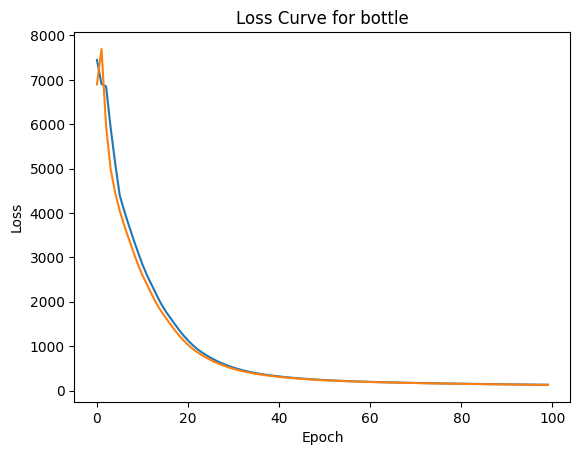

In [20]:
import json

# 读取 loss 文件
loss_file_path = f"losses/{category}_loss.json"
with open(loss_file_path, "r") as f:
    loss_data = json.load(f)

train_losses = np.array(loss_data["train_losses"])
val_losses = np.array(loss_data["val_losses"])


def remove_outliers(data, threshold=1e6):
    """去除大于指定阈值的异常值"""
    return np.where(data > threshold, np.nan, data)


train_losses_clean = remove_outliers(train_losses)
val_losses_clean = remove_outliers(val_losses)
# 可视化损失曲线
plt.plot(train_losses_clean, label="Training Loss")
plt.plot(val_losses_clean, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title(f"Loss Curve for {category}")
plt.show()

In [27]:
import matplotlib.pyplot as plt
import os
import torch
import torch.optim as optim

# 设置类别与设备
category = "cable"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
latent_dim = 256

print(f"Training DeepVAE for category: {category}")

# 初始化模型和优化器
model = VAE(latent_dim=latent_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# 模型保存路径
model_path = f"models/{category}_vae.pth"

# 加载预训练模型（如果存在）
if os.path.exists(model_path):
    print(
        f"Loading pre-trained weights for category: {category} from {model_path}")
    model.load_state_dict(torch.load(model_path))
else:
    print(
        f"No pre-trained weights found for category: {category}. Training from scratch.")

# 定义训练与验证的 DataLoader
train_loader = train_loaders[category]
val_loader = val_loaders[category]

# 训练模型
train_losses, val_losses = train_vae(
    model, train_loader, val_loader, optimizer, epochs=100)

# 保存模型
torch.save(model.state_dict(), model_path)
print(f"VAE model for category '{category}' saved at {model_path}.\n")

Training DeepVAE for category: cable
No pre-trained weights found for category: cable. Training from scratch.
Epoch [1/100], Train Loss: 3252.9012, Val Loss: 2960.1188
Epoch [2/100], Train Loss: 2973.0496, Val Loss: 99254.6556
Epoch [3/100], Train Loss: 7670.6599, Val Loss: 2306.0512
Epoch [4/100], Train Loss: 2317.8387, Val Loss: 2028.6293
Epoch [5/100], Train Loss: 2039.9824, Val Loss: 1824.3191
Epoch [6/100], Train Loss: 1836.0838, Val Loss: 1670.6177
Epoch [7/100], Train Loss: 1682.5866, Val Loss: 1548.5441
Epoch [8/100], Train Loss: 1560.4330, Val Loss: 1447.7516
Epoch [9/100], Train Loss: 1459.6945, Val Loss: 1362.8754
Epoch [10/100], Train Loss: 1375.1262, Val Loss: 1290.3754
Epoch [11/100], Train Loss: 1302.9836, Val Loss: 1228.2952
Epoch [12/100], Train Loss: 1241.0828, Val Loss: 1174.6319
Epoch [13/100], Train Loss: 1187.4390, Val Loss: 1127.6813
Epoch [14/100], Train Loss: 1140.4714, Val Loss: 1086.0321
Epoch [15/100], Train Loss: 1098.9618, Val Loss: 1048.6939
Epoch [16/100

In [28]:
# 保存 loss 到文件
import json

loss_file_path = f"losses/{category}_loss.json"
loss_data = {
   "train_losses": train_losses,
    "val_losses": val_losses
}
with open(loss_file_path, "w") as f:
    json.dump(loss_data, f, indent=4)  # 使用 JSON 格式保存
print(f"Losses for category '{category}' saved at {loss_file_path}.\n")

Losses for category 'cable' saved at losses/cable_loss.json.



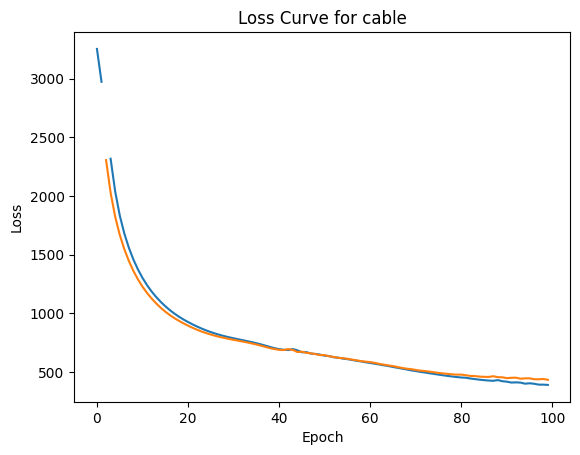

In [31]:
import json

# 读取 loss 文件
loss_file_path = f"losses/{category}_loss.json"
with open(loss_file_path, "r") as f:
    loss_data = json.load(f)

train_losses = np.array(loss_data["train_losses"])
val_losses = np.array(loss_data["val_losses"])


def remove_outliers(data, threshold=5e3):
    """去除大于指定阈值的异常值"""
    return np.where(data > threshold, np.nan, data)


train_losses_clean = remove_outliers(train_losses)
val_losses_clean = remove_outliers(val_losses)
# 可视化损失曲线
plt.plot(train_losses_clean, label="Training Loss")
plt.plot(val_losses_clean, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title(f"Loss Curve for {category}")
plt.show()

In [33]:
import matplotlib.pyplot as plt
import os
import torch
import torch.optim as optim

# 设置类别与设备
category = "capsule"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
latent_dim = 256

print(f"Training DeepVAE for category: {category}")

# 初始化模型和优化器
model = VAE(latent_dim=latent_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# 模型保存路径
model_path = f"models/{category}_vae.pth"

# 加载预训练模型（如果存在）
if os.path.exists(model_path):
    print(
        f"Loading pre-trained weights for category: {category} from {model_path}")
    model.load_state_dict(torch.load(model_path))
else:
    print(
        f"No pre-trained weights found for category: {category}. Training from scratch.")

# 定义训练与验证的 DataLoader
train_loader = train_loaders[category]
val_loader = val_loaders[category]

# 训练模型
train_losses, val_losses = train_vae(
    model, train_loader, val_loader, optimizer, epochs=100)

# 保存模型
torch.save(model.state_dict(), model_path)
print(f"VAE model for category '{category}' saved at {model_path}.\n")

Training DeepVAE for category: capsule
No pre-trained weights found for category: capsule. Training from scratch.
Epoch [1/100], Train Loss: 5412.3036, Val Loss: 4911.1644
Epoch [2/100], Train Loss: 4936.4200, Val Loss: 34412305.4545
Epoch [3/100], Train Loss: 2273463.0400, Val Loss: 3767.5696
Epoch [4/100], Train Loss: 3784.1539, Val Loss: 3073.6012
Epoch [5/100], Train Loss: 3087.2557, Val Loss: 2533.1085
Epoch [6/100], Train Loss: 2544.3596, Val Loss: 2122.4821
Epoch [7/100], Train Loss: 2131.8239, Val Loss: 1805.7138
Epoch [8/100], Train Loss: 1813.5246, Val Loss: 1554.4379
Epoch [9/100], Train Loss: 1560.9652, Val Loss: 1347.9574
Epoch [10/100], Train Loss: 1353.3096, Val Loss: 1172.9943
Epoch [11/100], Train Loss: 1177.1939, Val Loss: 1021.6070
Epoch [12/100], Train Loss: 1024.6112, Val Loss: 889.7827
Epoch [13/100], Train Loss: 891.5661, Val Loss: 776.0836
Epoch [14/100], Train Loss: 776.6822, Val Loss: 678.4147
Epoch [15/100], Train Loss: 677.8893, Val Loss: 594.9078
Epoch [16/

In [34]:
# 保存 loss 到文件
import json

loss_file_path = f"losses/{category}_loss.json"
loss_data = {
   "train_losses": train_losses,
    "val_losses": val_losses
}
with open(loss_file_path, "w") as f:
    json.dump(loss_data, f, indent=4)  # 使用 JSON 格式保存
print(f"Losses for category '{category}' saved at {loss_file_path}.\n")

Losses for category 'capsule' saved at losses/capsule_loss.json.



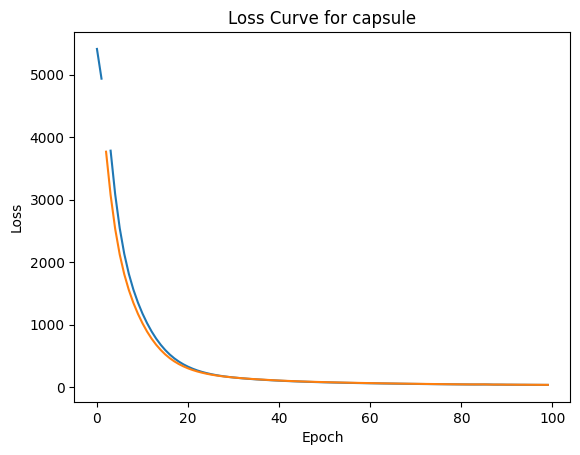

In [36]:
import json

# 读取 loss 文件
loss_file_path = f"losses/{category}_loss.json"
with open(loss_file_path, "r") as f:
    loss_data = json.load(f)

train_losses = np.array(loss_data["train_losses"])
val_losses = np.array(loss_data["val_losses"])


def remove_outliers(data, threshold=1e4):
    """去除大于指定阈值的异常值"""
    return np.where(data > threshold, np.nan, data)


train_losses_clean = remove_outliers(train_losses)
val_losses_clean = remove_outliers(val_losses)
# 可视化损失曲线
plt.plot(train_losses_clean, label="Training Loss")
plt.plot(val_losses_clean, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title(f"Loss Curve for {category}")
plt.show()

In [38]:
import matplotlib.pyplot as plt
import os
import torch
import torch.optim as optim

# 设置类别与设备
category = "pill"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
latent_dim = 256

print(f"Training DeepVAE for category: {category}")

# 初始化模型和优化器
model = VAE(latent_dim=latent_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# 模型保存路径
model_path = f"models/{category}_vae.pth"

# 加载预训练模型（如果存在）
if os.path.exists(model_path):
    print(
        f"Loading pre-trained weights for category: {category} from {model_path}")
    model.load_state_dict(torch.load(model_path))
else:
    print(
        f"No pre-trained weights found for category: {category}. Training from scratch.")

# 定义训练与验证的 DataLoader
train_loader = train_loaders[category]
val_loader = val_loaders[category]

# 训练模型
train_losses, val_losses = train_vae(
    model, train_loader, val_loader, optimizer, epochs=100)

# 保存模型
torch.save(model.state_dict(), model_path)
print(f"VAE model for category '{category}' saved at {model_path}.\n")

Training DeepVAE for category: pill
No pre-trained weights found for category: pill. Training from scratch.
Epoch [1/100], Train Loss: 7592.5822, Val Loss: 6812.3079
Epoch [2/100], Train Loss: 6848.5035, Val Loss: 5217.9780
Epoch [3/100], Train Loss: 5273.7594, Val Loss: 4438.6722
Epoch [4/100], Train Loss: 4461.8753, Val Loss: 3845.1753
Epoch [5/100], Train Loss: 3866.5907, Val Loss: 3363.4905
Epoch [6/100], Train Loss: 3383.0628, Val Loss: 2995.6415
Epoch [7/100], Train Loss: 3013.4428, Val Loss: 2680.0286
Epoch [8/100], Train Loss: 2696.4378, Val Loss: 2405.8924
Epoch [9/100], Train Loss: 2421.2576, Val Loss: 2178.2714
Epoch [10/100], Train Loss: 2192.7117, Val Loss: 1977.6515
Epoch [11/100], Train Loss: 1991.0842, Val Loss: 1793.7833
Epoch [12/100], Train Loss: 1806.1787, Val Loss: 1628.7002
Epoch [13/100], Train Loss: 1640.1161, Val Loss: 1483.6345
Epoch [14/100], Train Loss: 1494.1808, Val Loss: 1352.8469
Epoch [15/100], Train Loss: 1362.6697, Val Loss: 1232.0095
Epoch [16/100], 

In [39]:
# 保存 loss 到文件
import json

loss_file_path = f"losses/{category}_loss.json"
loss_data = {
   "train_losses": train_losses,
    "val_losses": val_losses
}
with open(loss_file_path, "w") as f:
    json.dump(loss_data, f, indent=4)  # 使用 JSON 格式保存
print(f"Losses for category '{category}' saved at {loss_file_path}.\n")

Losses for category 'pill' saved at losses/pill_loss.json.



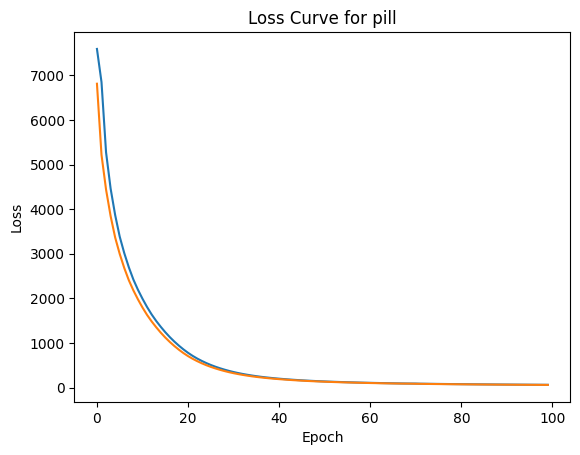

In [40]:
import json

# 读取 loss 文件
loss_file_path = f"losses/{category}_loss.json"
with open(loss_file_path, "r") as f:
    loss_data = json.load(f)

train_losses = np.array(loss_data["train_losses"])
val_losses = np.array(loss_data["val_losses"])


def remove_outliers(data, threshold=1e4):
    """去除大于指定阈值的异常值"""
    return np.where(data > threshold, np.nan, data)


train_losses_clean = remove_outliers(train_losses)
val_losses_clean = remove_outliers(val_losses)
# 可视化损失曲线
plt.plot(train_losses_clean, label="Training Loss")
plt.plot(val_losses_clean, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title(f"Loss Curve for {category}")
plt.show()

In [43]:
import matplotlib.pyplot as plt
import os
import torch
import torch.optim as optim

# 设置类别与设备
category = "toothbrush"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
latent_dim = 256

print(f"Training DeepVAE for category: {category}")

# 初始化模型和优化器
model = VAE(latent_dim=latent_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# 模型保存路径
model_path = f"models/{category}_vae.pth"

# 加载预训练模型（如果存在）
if os.path.exists(model_path):
    print(
        f"Loading pre-trained weights for category: {category} from {model_path}")
    model.load_state_dict(torch.load(model_path))
else:
    print(
        f"No pre-trained weights found for category: {category}. Training from scratch.")

# 定义训练与验证的 DataLoader
train_loader = train_loaders[category]
val_loader = val_loaders[category]

# 训练模型
train_losses, val_losses = train_vae(
    model, train_loader, val_loader, optimizer, epochs=100)

# 保存模型
torch.save(model.state_dict(), model_path)
print(f"VAE model for category '{category}' saved at {model_path}.\n")

Training DeepVAE for category: toothbrush
No pre-trained weights found for category: toothbrush. Training from scratch.
Epoch [1/100], Train Loss: 7706.4219, Val Loss: 7151.3678
Epoch [2/100], Train Loss: 7100.6087, Val Loss: 710441.1667
Epoch [3/100], Train Loss: 1986320.5000, Val Loss: 5869.1237
Epoch [4/100], Train Loss: 5859.1543, Val Loss: 5286.1055
Epoch [5/100], Train Loss: 5277.0618, Val Loss: 4793.6689
Epoch [6/100], Train Loss: 4785.8607, Val Loss: 4366.2952
Epoch [7/100], Train Loss: 4352.9980, Val Loss: 3987.8382
Epoch [8/100], Train Loss: 3967.2565, Val Loss: 3649.1755
Epoch [9/100], Train Loss: 3622.8158, Val Loss: 3344.9215
Epoch [10/100], Train Loss: 3315.8444, Val Loss: 3070.5306
Epoch [11/100], Train Loss: 3041.8620, Val Loss: 2814.3099
Epoch [12/100], Train Loss: 2787.1390, Val Loss: 2571.9232
Epoch [13/100], Train Loss: 2545.4670, Val Loss: 2347.0018
Epoch [14/100], Train Loss: 2320.4331, Val Loss: 2141.4020
Epoch [15/100], Train Loss: 2114.8682, Val Loss: 1955.0184

In [44]:
# 保存 loss 到文件
import json

loss_file_path = f"losses/{category}_loss.json"
loss_data = {
   "train_losses": train_losses,
    "val_losses": val_losses
}
with open(loss_file_path, "w") as f:
    json.dump(loss_data, f, indent=4)  # 使用 JSON 格式保存
print(f"Losses for category '{category}' saved at {loss_file_path}.\n")

Losses for category 'toothbrush' saved at losses/toothbrush_loss.json.



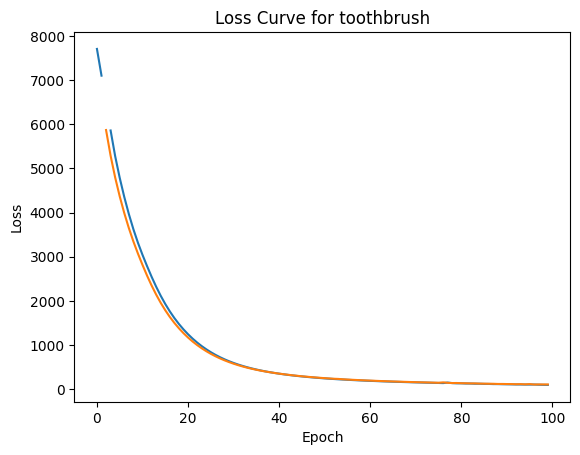

In [45]:
import json

# 读取 loss 文件
loss_file_path = f"losses/{category}_loss.json"
with open(loss_file_path, "r") as f:
    loss_data = json.load(f)

train_losses = np.array(loss_data["train_losses"])
val_losses = np.array(loss_data["val_losses"])


def remove_outliers(data, threshold=1e4):
    """去除大于指定阈值的异常值"""
    return np.where(data > threshold, np.nan, data)


train_losses_clean = remove_outliers(train_losses)
val_losses_clean = remove_outliers(val_losses)
# 可视化损失曲线
plt.plot(train_losses_clean, label="Training Loss")
plt.plot(val_losses_clean, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title(f"Loss Curve for {category}")
plt.show()

## Calculate the reconstruction loss
The reconstruction loss between good products and defective products should have difference.

You can use the following codes to evaluate the reconstruction loss, and find something useful information.

In [22]:
import os
import torch
from PIL import Image
import matplotlib.pyplot as plt


def test(image_path, vae, device):
    img = Image.open(image_path)
    img = transform(img).to(device)
    img = img.unsqueeze(0)

    vae.eval()
    with torch.no_grad():
        recon, mu, log_var = vae(img)
        test_loss = loss_function(recon, img, mu, log_var)
        return test_loss.item()


test_root = "./data/test"  # 测试数据的根目录

/tmp/ipykernel_2360198/305565116.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


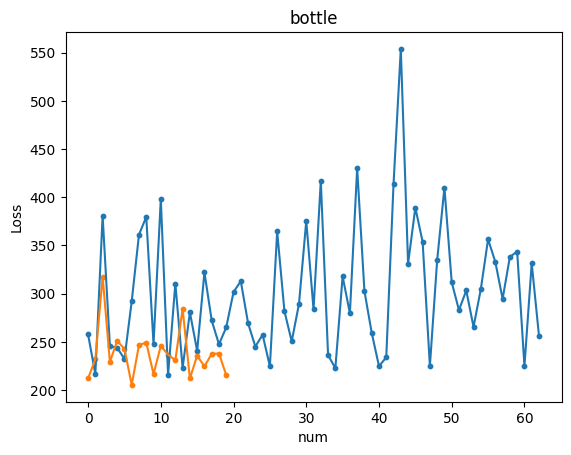

good avg:  238.24238204956055
defective avg:  301.1782623775422


In [65]:

category = "bottle"
latent_dim = 128
testimg_dir = os.path.join(test_root, category, "good")
testimg_dir2 = os.path.join(test_root, category, "error")

good = []
error = []
model = VAE(latent_dim).to(device)
model_path = f"models/{category}_vae.pth"
model.load_state_dict(torch.load(model_path))

for img_file in os.listdir(testimg_dir):
    img_path = os.path.join(testimg_dir, img_file)
    if os.path.isfile(img_path):
        test(img_path, model, device)
        good.append(test(img_path, model, device))

for img_file in os.listdir(testimg_dir2):
    img_path = os.path.join(testimg_dir2, img_file)
    if os.path.isfile(img_path):
        test(img_path, model, device)
        error.append(test(img_path, model, device))

plt.plot(error, label='defective Loss')
plt.scatter(range(len(error)), error, s=10)
plt.plot(good, label='good Loss')
plt.scatter(range(len(good)), good, s=10)
plt.xlabel('num')
plt.ylabel('Loss')
plt.title(category)
plt.show()
print("good avg: ", sum(good)/len(good))
print("defective avg: ", sum(error)/len(error))

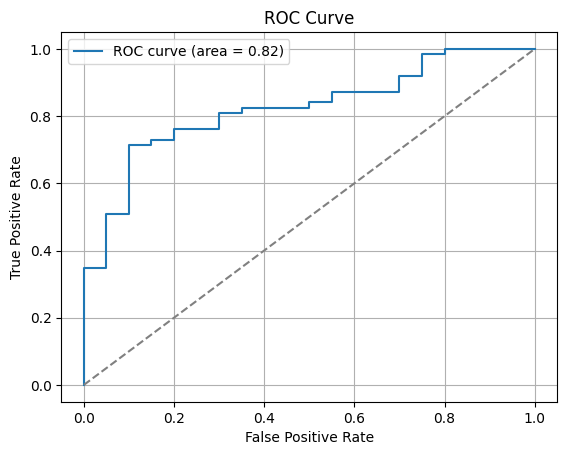

Optimal Threshold: 256.34
Threshold for category 'bottle' saved: 256.34136962890625
Saved thresholds: {'toothbrush': 162.6009521484375, 'pill': 273.07373046875, 'capsule': 101.38514709472656, 'cable': 567.5994262695312, 'bottle': 256.34136962890625}


In [66]:
from sklearn.metrics import roc_curve, auc

# 准备标签和损失数据
labels = [0] * len(good) + [1] * len(error)  # 0: Good, 1: Defective
losses = good + error

# 计算 FPR, TPR 和阈值
fpr, tpr, thresholds = roc_curve(labels, losses)
roc_auc = auc(fpr, tpr)

# 绘制 ROC 曲线
plt.plot(fpr, tpr, label=f"ROC curve (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.show()

# 找到最佳阈值
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print(f"Optimal Threshold: {optimal_threshold:.2f}")

threshold_file = "thresholds.json"

# 加载已有的阈值文件（如果存在）
try:
    with open(threshold_file, "r") as f:
        thresholds = json.load(f)
except FileNotFoundError:
    thresholds = {}

# 更新当前类别的阈值
thresholds[category] = optimal_threshold

# 保存阈值到文件
with open(threshold_file, "w") as f:
    json.dump(thresholds, f, indent=4)
    print(f"Threshold for category '{category}' saved: {optimal_threshold}")

# 验证保存内容
print(f"Saved thresholds: {thresholds}")

/tmp/ipykernel_2360198/1620187887.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


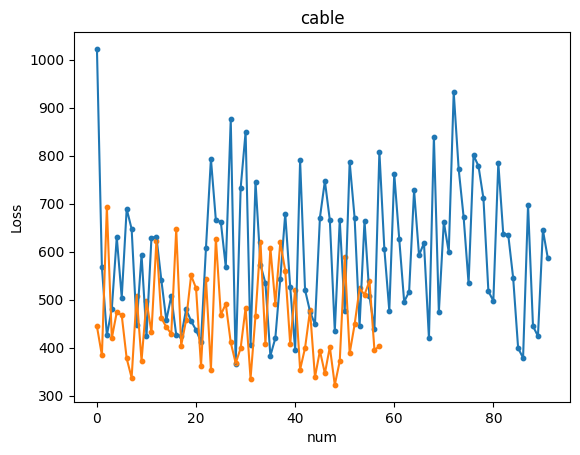

good avg:  460.2056337553879
defective avg:  588.9149995886761


In [63]:
category = "cable"
latent_dim = 256
testimg_dir = os.path.join(test_root, category, "good")
testimg_dir2 = os.path.join(test_root, category, "error")

good = []
error = []
model = VAE(latent_dim).to(device)
model_path = f"models/{category}_vae.pth"
model.load_state_dict(torch.load(model_path))

for img_file in os.listdir(testimg_dir):
    img_path = os.path.join(testimg_dir, img_file)
    if os.path.isfile(img_path):
        test(img_path, model, device)
        good.append(test(img_path, model, device))

for img_file in os.listdir(testimg_dir2):
    img_path = os.path.join(testimg_dir2, img_file)
    if os.path.isfile(img_path):
        test(img_path, model, device)
        error.append(test(img_path, model, device))

plt.plot(error, label='defective Loss')
plt.scatter(range(len(error)), error, s=10)
plt.plot(good, label='good Loss')
plt.scatter(range(len(good)), good, s=10)
plt.xlabel('num')
plt.ylabel('Loss')
plt.title(category)
plt.show()
print("good avg: ", sum(good)/len(good))
print("defective avg: ", sum(error)/len(error))

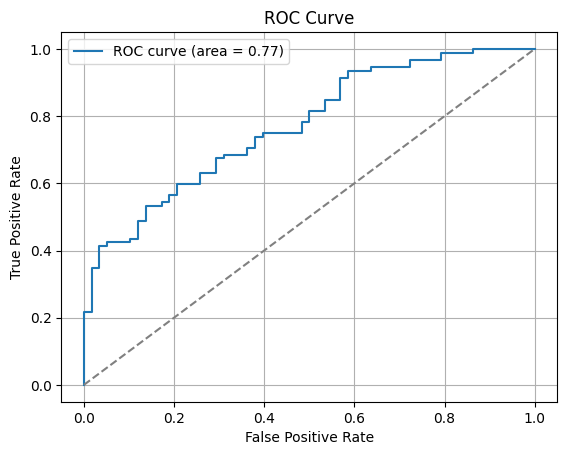

Optimal Threshold: 567.60
Threshold for category 'cable' saved: 567.5994262695312
Saved thresholds: {'toothbrush': 162.6009521484375, 'pill': 273.07373046875, 'capsule': 101.38514709472656, 'cable': 567.5994262695312}


In [64]:
from sklearn.metrics import roc_curve, auc

# 准备标签和损失数据
labels = [0] * len(good) + [1] * len(error)  # 0: Good, 1: Defective
losses = good + error

# 计算 FPR, TPR 和阈值
fpr, tpr, thresholds = roc_curve(labels, losses)
roc_auc = auc(fpr, tpr)

# 绘制 ROC 曲线
plt.plot(fpr, tpr, label=f"ROC curve (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.show()

# 找到最佳阈值
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print(f"Optimal Threshold: {optimal_threshold:.2f}")

threshold_file = "thresholds.json"

# 加载已有的阈值文件（如果存在）
try:
    with open(threshold_file, "r") as f:
        thresholds = json.load(f)
except FileNotFoundError:
    thresholds = {}

# 更新当前类别的阈值
thresholds[category] = optimal_threshold

# 保存阈值到文件
with open(threshold_file, "w") as f:
    json.dump(thresholds, f, indent=4)
    print(f"Threshold for category '{category}' saved: {optimal_threshold}")

# 验证保存内容
print(f"Saved thresholds: {thresholds}")

In [ ]:
from sklearn.metrics import roc_curve, auc

# 准备标签和损失数据
labels = [0] * len(good) + [1] * len(error)  # 0: Good, 1: Defective
losses = good + error

# 计算 FPR, TPR 和阈值
fpr, tpr, thresholds = roc_curve(labels, losses)
roc_auc = auc(fpr, tpr)

# 绘制 ROC 曲线
plt.plot(fpr, tpr, label=f"ROC curve (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.show()

# 找到最佳阈值
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print(f"Optimal Threshold: {optimal_threshold:.2f}")

threshold_file = "thresholds.json"

# 加载已有的阈值文件（如果存在）
try:
    with open(threshold_file, "r") as f:
        thresholds = json.load(f)
except FileNotFoundError:
    thresholds = {}

# 更新当前类别的阈值
thresholds[category] = optimal_threshold

# 保存阈值到文件
with open(threshold_file, "w") as f:
    json.dump(thresholds, f, indent=4)
    print(f"Threshold for category '{category}' saved: {optimal_threshold}")

# 验证保存内容
print(f"Saved thresholds: {thresholds}")

/tmp/ipykernel_2360198/1144266254.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


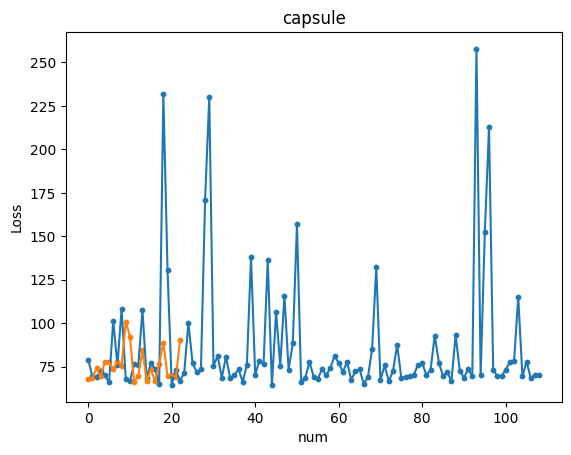

good avg:  75.91712818975034
defective avg:  85.6716594871031


In [58]:
category = "capsule"
latent_dim = 256
testimg_dir = os.path.join(test_root, category, "good")
testimg_dir2 = os.path.join(test_root, category, "error")

good = []
error = []
model = VAE(latent_dim).to(device)
model_path = f"models/{category}_vae.pth"
model.load_state_dict(torch.load(model_path))

for img_file in os.listdir(testimg_dir):
    img_path = os.path.join(testimg_dir, img_file)
    if os.path.isfile(img_path):
        test(img_path, model, device)
        good.append(test(img_path, model, device))

for img_file in os.listdir(testimg_dir2):
    img_path = os.path.join(testimg_dir2, img_file)
    if os.path.isfile(img_path):
        test(img_path, model, device)
        error.append(test(img_path, model, device))

plt.plot(error, label='defective Loss')
plt.scatter(range(len(error)), error, s=10)
plt.plot(good, label='good Loss')
plt.scatter(range(len(good)), good, s=10)
plt.xlabel('num')
plt.ylabel('Loss')
plt.title(category)
plt.show()
print("good avg: ", sum(good)/len(good))
print("defective avg: ", sum(error)/len(error))

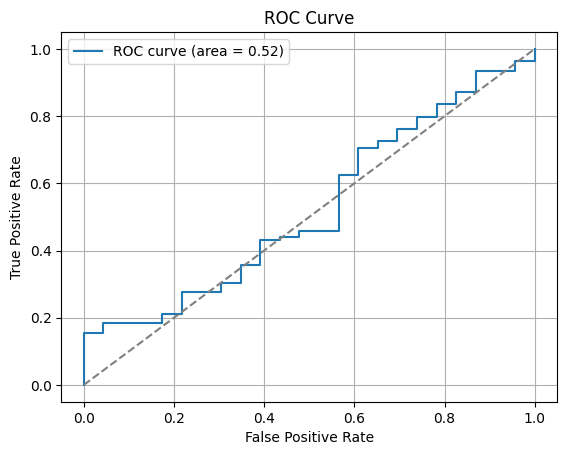

Optimal Threshold: 101.39
Threshold for category 'capsule' saved: 101.38514709472656
Saved thresholds: {'toothbrush': 162.6009521484375, 'pill': 273.07373046875, 'capsule': 101.38514709472656}


In [59]:
from sklearn.metrics import roc_curve, auc

# 准备标签和损失数据
labels = [0] * len(good) + [1] * len(error)  # 0: Good, 1: Defective
losses = good + error

# 计算 FPR, TPR 和阈值
fpr, tpr, thresholds = roc_curve(labels, losses)
roc_auc = auc(fpr, tpr)

# 绘制 ROC 曲线
plt.plot(fpr, tpr, label=f"ROC curve (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.show()

# 找到最佳阈值
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print(f"Optimal Threshold: {optimal_threshold:.2f}")

threshold_file = "thresholds.json"

# 加载已有的阈值文件（如果存在）
try:
    with open(threshold_file, "r") as f:
        thresholds = json.load(f)
except FileNotFoundError:
    thresholds = {}

# 更新当前类别的阈值
thresholds[category] = optimal_threshold

# 保存阈值到文件
with open(threshold_file, "w") as f:
    json.dump(thresholds, f, indent=4)
    print(f"Threshold for category '{category}' saved: {optimal_threshold}")

# 验证保存内容
print(f"Saved thresholds: {thresholds}")

/tmp/ipykernel_2360198/3020332005.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


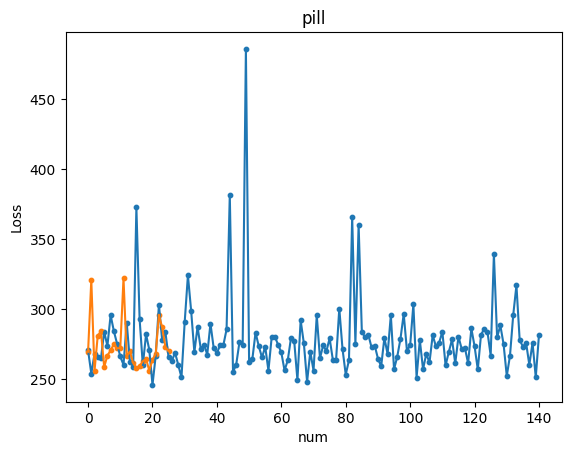

good avg:  273.1745077279898
defective avg:  277.989360295289


In [56]:

category = "pill"
latent_dim = 256
testimg_dir = os.path.join(test_root, category, "good")
testimg_dir2 = os.path.join(test_root, category, "error")

good = []
error = []
model = VAE(latent_dim).to(device)
model_path = f"models/{category}_vae.pth"
model.load_state_dict(torch.load(model_path))

for img_file in os.listdir(testimg_dir):
    img_path = os.path.join(testimg_dir, img_file)
    if os.path.isfile(img_path):
        test(img_path, model, device)
        good.append(test(img_path, model, device))

for img_file in os.listdir(testimg_dir2):
    img_path = os.path.join(testimg_dir2, img_file)
    if os.path.isfile(img_path):
        test(img_path, model, device)
        error.append(test(img_path, model, device))

plt.plot(error, label='defective Loss')
plt.scatter(range(len(error)), error, s=10)
plt.plot(good, label='good Loss')
plt.scatter(range(len(good)), good, s=10)
plt.xlabel('num')
plt.ylabel('Loss')
plt.title(category)
plt.show()
print("good avg: ", sum(good)/len(good))
print("defective avg: ", sum(error)/len(error))

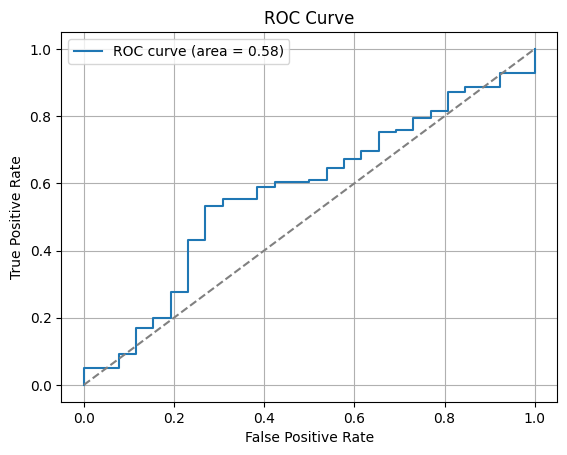

Optimal Threshold: 273.07
Threshold for category 'pill' saved: 273.07373046875
Saved thresholds: {'toothbrush': 162.6009521484375, 'pill': 273.07373046875}


In [57]:
from sklearn.metrics import roc_curve, auc

# 准备标签和损失数据
labels = [0] * len(good) + [1] * len(error)  # 0: Good, 1: Defective
losses = good + error

# 计算 FPR, TPR 和阈值
fpr, tpr, thresholds = roc_curve(labels, losses)
roc_auc = auc(fpr, tpr)

# 绘制 ROC 曲线
plt.plot(fpr, tpr, label=f"ROC curve (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.show()

# 找到最佳阈值
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print(f"Optimal Threshold: {optimal_threshold:.2f}")

threshold_file = "thresholds.json"

# 加载已有的阈值文件（如果存在）
try:
    with open(threshold_file, "r") as f:
        thresholds = json.load(f)
except FileNotFoundError:
    thresholds = {}

# 更新当前类别的阈值
thresholds[category] = optimal_threshold

# 保存阈值到文件
with open(threshold_file, "w") as f:
    json.dump(thresholds, f, indent=4)
    print(f"Threshold for category '{category}' saved: {optimal_threshold}")

# 验证保存内容
print(f"Saved thresholds: {thresholds}")

/tmp/ipykernel_2360198/2967606563.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


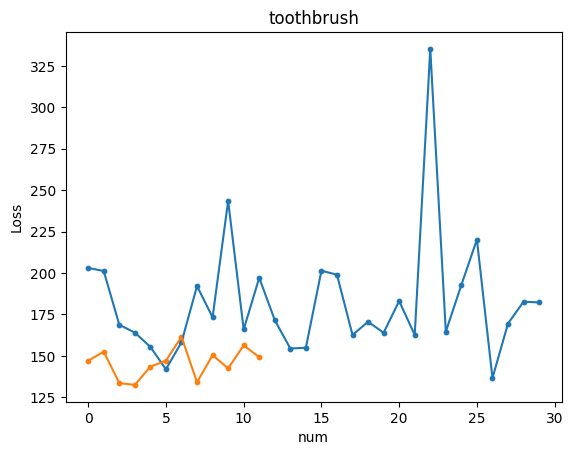

good avg:  145.82945251464844
defective avg:  182.3980494181315


In [53]:

category = "toothbrush"
latent_dim = 256
testimg_dir = os.path.join(test_root, category, "good")
testimg_dir2 = os.path.join(test_root, category, "error")

good = []
error = []
model = VAE(latent_dim).to(device)
model_path = f"models/{category}_vae.pth"
model.load_state_dict(torch.load(model_path))

for img_file in os.listdir(testimg_dir):
    img_path = os.path.join(testimg_dir, img_file)
    if os.path.isfile(img_path):
        test(img_path, model, device)
        good.append(test(img_path, model, device))

for img_file in os.listdir(testimg_dir2):
    img_path = os.path.join(testimg_dir2, img_file)
    if os.path.isfile(img_path):
        test(img_path, model, device)
        error.append(test(img_path, model, device))

plt.plot(error, label='defective Loss')
plt.scatter(range(len(error)), error, s=10)
plt.plot(good, label='good Loss')
plt.scatter(range(len(good)), good, s=10)
plt.xlabel('num')
plt.ylabel('Loss')
plt.title(category)
plt.show()
print("good avg: ", sum(good)/len(good))
print("defective avg: ", sum(error)/len(error))

In [48]:
import torch.multiprocessing as mp
mp.set_start_method('spawn', force=True)


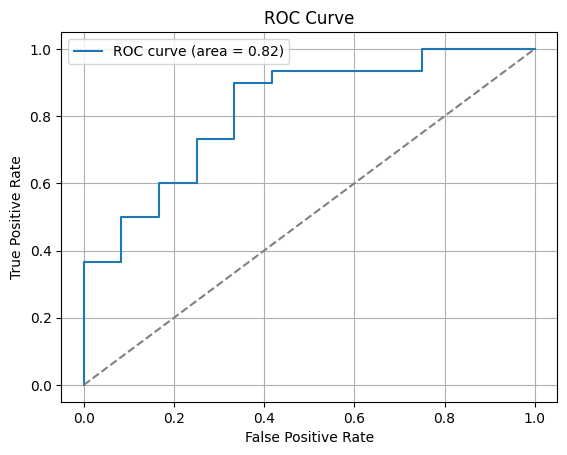

Optimal Threshold: 155.78
Threshold for category 'toothbrush' saved: 155.7772216796875
Saved thresholds: {'toothbrush': 155.7772216796875}


In [52]:
from sklearn.metrics import roc_curve, auc

# 准备标签和损失数据
labels = [0] * len(good) + [1] * len(error)  # 0: Good, 1: Defective
losses = good + error

# 计算 FPR, TPR 和阈值
fpr, tpr, thresholds = roc_curve(labels, losses)
roc_auc = auc(fpr, tpr)

# 绘制 ROC 曲线
plt.plot(fpr, tpr, label=f"ROC curve (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.show()

# 找到最佳阈值
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print(f"Optimal Threshold: {optimal_threshold:.2f}")

threshold_file = "thresholds.json"

# 加载已有的阈值文件（如果存在）
try:
    with open(threshold_file, "r") as f:
        thresholds = json.load(f)
except FileNotFoundError:
    thresholds = {}

# 更新当前类别的阈值
thresholds[category] = optimal_threshold

# 保存阈值到文件
with open(threshold_file, "w") as f:
    json.dump(thresholds, f, indent=4)
    print(f"Threshold for category '{category}' saved: {optimal_threshold}")

# 验证保存内容
print(f"Saved thresholds: {thresholds}")


## Calculate Accuracy
You need to calculate the accuracy of products' predictions. 

A easy way is to use the reconstruction loss to distinguish between goods and defective ones.

It is not restricted to use this way, you also can use another methods and write they into report.

In [72]:
def calculate_accuracy(data_path, model, device, threshold):
    total = 0
    correct = 0

    for img_file in os.listdir(data_path):
        img_path = os.path.join(data_path, img_file)
        if os.path.isfile(img_path):
            loss = test(img_path, model, device)  # 获取图片的重构损失
            total += 1
            if (loss < threshold and "good" in data_path) or (loss >= threshold and "error" in data_path):
                correct += 1
    return correct / total if total > 0 else 0


In [77]:
import os
import json

# 假设 threshold_file 已经保存了所有类别的阈值
threshold_file = "thresholds.json"

# 加载阈值文件
try:
    with open(threshold_file, "r") as f:
        thresholds = json.load(f)
except FileNotFoundError:
    print(f"Threshold file '{threshold_file}' not found.")
    thresholds = {}
    
# 自动生成 categories 列表
categories = [d for d in os.listdir(test_root) if os.path.isdir(os.path.join(test_root, d))]

print(f"Detected categories: {categories}")
# 遍历所有类别并计算准确率
for category in categories:
    category_path = os.path.join(test_root, category)
    if os.path.isdir(category_path):  # 确保是目录
        good_path = os.path.join(category_path, "good")
        error_path = os.path.join(category_path, "error")

        # 从 JSON 中读取该类别的阈值
        threshold = thresholds.get(category, None)
        if threshold is None:
            print(f"Threshold for category '{category}' not found in {threshold_file}. Skipping...")
            continue
        if category == "bottle":
            latent_dim = 128
        else:
            latent_dim = 256
        model = VAE(latent_dim).to(device)
        model_path = f"models/{category}_vae.pth"
        model.load_state_dict(torch.load(model_path, weights_only=True))
        # 计算 good 和 error 的准确率
        good_accuracy = calculate_accuracy(good_path, model, device, threshold)
        error_accuracy = calculate_accuracy(error_path, model, device, threshold)

        # 打印结果
        print(f"Category: {category}")
        print(f"  Threshold: {threshold:.2f}")
        print(f"  Good Accuracy: {good_accuracy:.2%}")
        print(f"  Error Accuracy: {error_accuracy:.2%}")
        print(f"  Overall Accuracy: {(good_accuracy + error_accuracy) / 2:.2%}\n")


Detected categories: ['bottle', 'pill', 'capsule', 'cable', 'toothbrush']
Category: bottle
  Threshold: 256.34
  Good Accuracy: 90.00%
  Error Accuracy: 71.43%
  Overall Accuracy: 80.71%

Category: pill
  Threshold: 273.07
  Good Accuracy: 69.23%
  Error Accuracy: 48.23%
  Overall Accuracy: 58.73%

Category: capsule
  Threshold: 101.39
  Good Accuracy: 100.00%
  Error Accuracy: 15.60%
  Overall Accuracy: 57.80%

Category: cable
  Threshold: 567.60
  Good Accuracy: 86.21%
  Error Accuracy: 53.26%
  Overall Accuracy: 69.73%

Category: toothbrush
  Threshold: 162.60
  Good Accuracy: 100.00%
  Error Accuracy: 76.67%
  Overall Accuracy: 88.33%

